In [104]:
import cv2
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline  

from projection_dataset import ProjectionDataset
from image_util import local_contrast_normalization, generate_heatmap_gt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
dataset_dir = "../data/projections"
subjects = ["P0", "P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8"]
gestures = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "I", "IP", "L", "MP", "RP", "T", "TIP", "Y"]

plane = "XY" # Other planes: YZ and ZX

In [106]:
dataset = ProjectionDataset(dataset_dir, subjects, gestures, plane)

torch.Size([1, 96, 96])


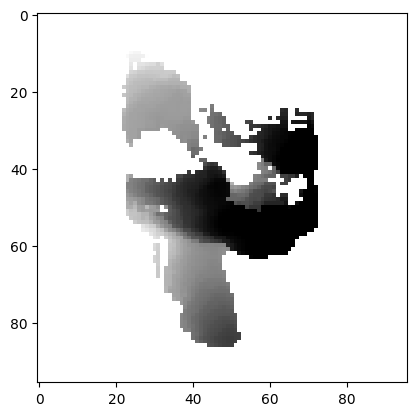

In [107]:
train_dataloader = DataLoader(dataset, batch_size = 1, shuffle=False)
test, bbox, joint_uvs, lengths, transform = next(iter(train_dataloader))
print(test.shape)
plt.imshow(torch.squeeze(test, 0).numpy(), cmap='gray', vmin=0, vmax=1)
plt.show()

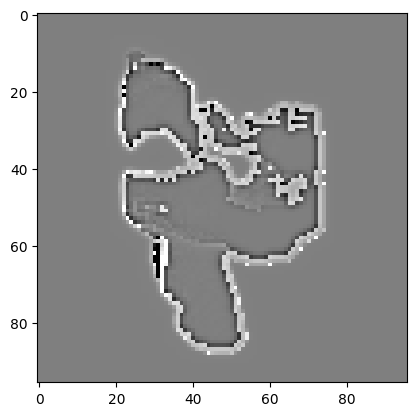

[tensor([8.], dtype=torch.float64), tensor([4.], dtype=torch.float64)]
[tensor([6.], dtype=torch.float64), tensor([9.], dtype=torch.float64)]
[tensor([6.], dtype=torch.float64), tensor([12.], dtype=torch.float64)]
[tensor([6.], dtype=torch.float64), tensor([14.], dtype=torch.float64)]
[tensor([7.], dtype=torch.float64), tensor([15.], dtype=torch.float64)]
[tensor([3.], dtype=torch.float64), tensor([9.], dtype=torch.float64)]
[tensor([10.], dtype=torch.float64), tensor([11.], dtype=torch.float64)]
[tensor([13.], dtype=torch.float64), tensor([9.], dtype=torch.float64)]
[tensor([11.], dtype=torch.float64), tensor([7.], dtype=torch.float64)]
[tensor([1.], dtype=torch.float64), tensor([8.], dtype=torch.float64)]
[tensor([7.], dtype=torch.float64), tensor([9.], dtype=torch.float64)]
[tensor([10.], dtype=torch.float64), tensor([9.], dtype=torch.float64)]
[tensor([12.], dtype=torch.float64), tensor([8.], dtype=torch.float64)]
[tensor([0.], dtype=torch.float64), tensor([6.], dtype=torch.float64

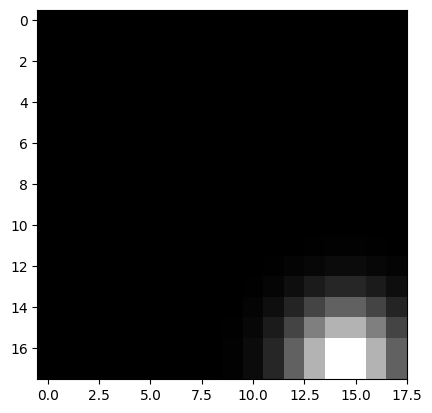

In [109]:
depth_image = torch.squeeze(test, 0).numpy()
result = local_contrast_normalization(depth_image)
plt.imshow(result, cmap='gray', vmin=-1, vmax=1)
plt.show()

result = generate_heatmap_gt(joint_uvs)
plt.imshow(result[0], cmap='gray', vmin=0, vmax=1)
plt.show()

In [52]:
# Configure the optimizer and criterion